# Analiza utjecaja vremenskih uvjeta na prometne nesreće

## Uvod

Prometne nesreće predstavljaju važan sigurnosni i društveni problem jer mogu imati ozbiljne posljedice. Na nastanak prometnih nesreća utječe velik broj čimbenika među kojima se često spominju vremenski uvjeti poput temperature, kiše i snijega. Iako se često pretpostavlja da loši vremenski uvjeti automatski povećavaju broj prometnih nesreća stvarni utjecaj pojedinih vremenskih čimbenika nije uvijek jednoznačan i može se razlikovati ovisno o regiji i sezoni.

U ovom projektu analizira se odnos između vremenskih uvjeta i prometnih nesreća korištenjem stvarnih podataka o prometnim nesrećama te meteoroloških podataka dobivenih putem javno dostupnog API-ja. Analiza obuhvaća razdoblje od 2016. do 2018. godine dok su godine obilježene pandemijom COVID-19 izostavljene kako bi se izbjegao utjecaj slabije gustoće prometa u to vrijeme. Poseban naglasak stavljen je na usporedbu količine prometnih nesreća i težine njihovih posljedica u različitim vremenskim uvjetima, kao i na prepoznavanje sezonalnih i regionalnih obrazaca.

## Motivacija

Motivacija za odabir ove teme proizlazi iz interesa kako vremenski uvjeti mogu utjecati na prometne nesreće. Živim u Zagrebu gdje su teške prometne nesreće svaki dan normalna pojava te se vremenski uvjeti često navode kao jedan od razloga povećanog rizika u prometu. Cilj projekta bio je provjeriti koliko su takve pretpostavke utemeljene na stvarnim podacima te razlikovati njihov utjecaj na sam broj nesreća i na težinu njihovih posljedica.

## Preuzimanje dataseta

Podatke o prometnim nesrećama preuzeo sam s javno dostupnog repozitorija Kaggle. Prilikom odabira dataseta koristio sam preporuku alata ChatGPT, koji je predložio skup podataka US Traffic Accidents NHTSA CRSS Accident Records 2016–2020, dostupan na poveznici: https://www.kaggle.com/datasets/jonbown/us-2020-traffic-accidents .

U ZIP arhivi nalaze se tri vrste CSV datoteka. Datoteke s prefiksom "acc" sadrže podatke o prometnim nesrećama i korištene su za analizu te integraciju s vremenskim podacima. Datoteke s prefiksima "pers" i "veh" sadrže dodatne informacije o osobama i vozilima uključenima u nesreće, no budući da ne sadrže podatke relevantne za analizu vremenskih uvjeta nisam ih koristio u analizi.

Za analizu sam odabrao tri specifične CSV datoteke: "acc_16", "acc_17" i "acc_18" koje sadrže podatke o prometnim nesrećama u SAD-u od 2016. do 2018. godine. CSV datoteke koje sadrže podatke o nesrećama iz 2019. i 2020. godine koristio s obzirom na COVID pandemiju koja je promijenila obrasce kretanja i gustoću prometa te bi mogla narušiti reprezentativnost rezultata.

## Open-Meteo API

Vremenske podatke dohvaćao sam putem javno dostupnog Open-Meteo API-ja, koji mi je također preporučio ChatGPT. API je dostupan na sljedećoj poveznici: https://open-meteo.com

Open-Meteo API omogućuje pristup povijesnim meteorološkim podacima u JSON formatu. API sam koristio za dohvat mjesečnih vremenskih podataka koji su kasnije integrirani s podacima o prometnim nesrećama. Prilikom dohvaćanja podataka koristio sam reprezentativne lokacije za svaku regiju kako bi vremenski podaci okvirno odgovarali području u kojem su se nesreće dogodile.

Dohvaćeni su podaci o prosječnoj mjesečnoj temperaturi, ukupnoj količini oborina, količini snijega te broju dana s oborinama. Budući da dataset o prometnim nesrećama ne sadrži precizne datume ni točne lokacije nesreća, vremenski podaci nisu dohvaćani za pojedinačne dane ili specifične lokacije, već su agregirani na mjesečnoj razini kako bi se mogli smisleno povezati s postojećim podacima.

## Priprema podataka

Krenuo sam učitavanjem potrebnih biblioteka i CSV datoteka koje ću koristiti. Svaka datoteka učitana je u zaseban dataframe. 

Zatim sam odabrao stupce koji su mi bitni i koje ću koristiti u analizi. Odabrani stupci uključuju identifikator nesreće, regiju, mjesec i godinu nastanka nesreće, podatak o urbanom ili ruralnom području, uvjete osvjetljenja, maksimalnu težinu ozljede te broj ozlijeđenih osoba.

Nakon što sam odabrao stupce, podaci iz svih godina su spojeni u jedan jedinstveni dataframe koji sadrži podatke o svim prometnim nesrećama za promatrano razdoblje. Također sam dodatno osigurao da je stupac s godinom zapisan u dobrom numeričkom formatu kako kasnije ne bi imao problema s time.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import requests

In [2]:
acc16 = pd.read_csv("acc_16.csv")
acc17 = pd.read_csv("acc_17.csv")
acc18 = pd.read_csv("acc_18.csv")

In [3]:
cols = [
    "CASENUM",
    "REGION",
    "MONTH",
    "YEAR",
    "URBANICITY",
    "LGT_COND",
    "MAX_SEV",
    "NUM_INJ"
]

In [4]:
acc16 = acc16[cols]
acc17 = acc17[cols]
acc18 = acc18[cols]

In [5]:
acc_all = pd.concat([acc16, acc17, acc18], ignore_index=True)
acc_all["YEAR"] = acc_all["YEAR"].astype(int)

Nakon što sam sve spojio obavio sam kratku provjeru strukture i podataka u dataframe-u kako bi se uvjerio da je sve ispravno.

In [6]:
acc_all.head()

,CASENUM,REGION,MONTH,YEAR,URBANICITY,LGT_COND,MAX_SEV,NUM_INJ
0,201600014311,4,1,2016,2,1,0,0
1,201600014315,4,1,2016,2,3,1,4
2,201600014316,4,1,2016,2,3,3,1
3,201600014335,4,1,2016,2,3,0,0
4,201600014586,4,1,2016,2,1,2,1


### Čišćenje i standardizacija prometnih podataka

Nakon spajanja godina, proveo sam standardizaciju podataka kako bi osigurao da su svi stupci u dobrom formatu.

Stupci za godinu, mjesec, regiju i tip područja pretvoreni su u cjelobrojni tip. Stupac za broj ozlijeđenih osoba dodatno je obrađen funkcijom za pretvorbu u numerički format te u slučajevima gdje se pojavljuju nedostajuće vrijednosit, one se zapisuju kao NaN.

Zatim su podaci filtrirani tako da se pokazuju samo one prometne nesreće koje su se dogodile u urbanim područjima. S obzirom da vremenski podaci nisu dostupni za preciznu lokaciju, analiza je ograničena na urbana područja kako bi vremenski uvjeti bili što reprezentativniji.

U podacima za nesreće, CASENUM stupac je jedinstveni identifikator svake nesreće samo za godinu u kojoj se nalazi podatak. Iz tog razloga sam kreirao jedinstveni identifikator nesreće kombiniranjem godine i izvornog identifikatora slučaja. Ovaj novi identifikator koristi se za označavanje svake nesreće unutar cijelog skupa podataka.

In [7]:
acc_all["YEAR"] = acc_all["YEAR"].astype(int)
acc_all["MONTH"] = acc_all["MONTH"].astype(int)
acc_all["REGION"] = acc_all["REGION"].astype(int)
acc_all["URBANICITY"] = acc_all["URBANICITY"].astype(int)

acc_all["NUM_INJ"] = pd.to_numeric(acc_all["NUM_INJ"], errors="coerce")

In [8]:
acc_all = acc_all[acc_all["URBANICITY"] == 1].copy()

In [9]:
acc_all["CRASH_ID"] = (
    acc_all["YEAR"].astype(str) + "_" + acc_all["CASENUM"].astype(str)
)

Nakon čišćenja podataka, ponovno sam obavio brzu provjeru.

In [10]:
acc_all.head()

,CASENUM,REGION,MONTH,YEAR,URBANICITY,LGT_COND,MAX_SEV,NUM_INJ,CRASH_ID
12,201600015251,4,1,2016,1,1,9,99,2016_201600015251
13,201600015256,4,1,2016,1,3,0,0,2016_201600015256
14,201600015257,4,1,2016,1,1,2,1,2016_201600015257
15,201600015268,4,1,2016,1,1,2,1,2016_201600015268
16,201600015305,2,1,2016,1,8,0,0,2016_201600015305


### Agregacija prometnih podataka na mjesečnu razinu

Podaci su zatim agregirani na mjesečnu razinu kako bi se mogli uspoređivati s vremenskim podacima, koji su također u mjesečnom obliku. Razlog agregacije prometnih i vremenskih podataka na mjesečnu razinu su nedostajući podaci o točnoj lokaciji i danu za svaku prometnu nesreću. U CSV datotekama postoje podaci o godini, mjesecu i danu u tjednu (ponedjeljak, utorak itd.), ali ne i o točnom datumu. Prvo sam pokušao napraviti neku vrstu prosječnog tjedna te odraditi analizu na taj način, spajajući sve ponedjeljke u mjesecu u jedan prosječni ponedjeljak i tako za sve dane tjedna. Ubrzo sam shvatio da taj način nije dobar za analizu te sam prešao na mjesečnu agregaciju podataka.

Podaci su grupirani prema regiji, godini i mjesecu. Za svaku kombinaciju regije, godine i mjeseca izračunate su tri metrike. Prva metrika predstavlja ukupan broj prometnih nesreća, koji se dobiva brojanjem jedinstvenih identifikatora nesreća. Druga metrika je ukupan broj ozlijeđenih osoba, dobiven zbrajanjem vrijednosti u stupcu koji označava broj ozlijeđenih po nesreći. Treća metrika odnosi se na broj teških nesreća, definirnih kao nesreće s fatalnim ishodom, koje su identificirane pomoću vrijednosti u stupcu maksimalne težine ozljede.

Nakon agregacije, rezultat je pretvoren u novi dataframe. Dobiveni podaci su zatim spremljeni u SQLite bazu podataka zajedno s prethodno obrađenim prometnim podacima.

In [11]:
acc_monthly = (
    acc_all
    .groupby(["REGION", "YEAR", "MONTH"])
    .agg(
        crashes=("CRASH_ID", "count"),
        injured_sum=("NUM_INJ", "sum"),
        severe_count=("MAX_SEV", lambda x: (x == 4).sum())
    )
    .reset_index()
)

In [12]:
conn = sqlite3.connect("baza.db")

acc_all.to_sql("accidents_urban_raw", conn, if_exists="replace", index=False)
acc_monthly.to_sql("accidents_urban_monthly", conn, if_exists="replace", index=False)

conn.close()

Kao i prije, nakon agregacija obavljena je brza provjera.

In [13]:
acc_monthly.head()

,REGION,YEAR,MONTH,crashes,injured_sum,severe_count
0,1,2016,1,425,1115,3
1,1,2016,2,435,1132,3
2,1,2016,3,364,884,5
3,1,2016,4,332,1077,2
4,1,2016,5,365,1332,5


## Dohvat i obrada vremenskih podataka

Vremenski podaci dohvaćeni su za lokacije koje odgovaraju pojedinim regijama. Za svaku regiju odabran je jedan veći grad kako bi vremenski podaci okvirno odgovarali klimatskim uvjetima tog područja s obzirom da se promatraju samo nesreće u urbanim područjima.

In [14]:
regions = {
    1: {"name": "Northeast", "lat": 40.7128, "lon": -74.0060}, #New York
    2: {"name": "Midwest",   "lat": 41.8781, "lon": -87.6298}, #Chicago
    3: {"name": "South",     "lat": 32.7767, "lon": -96.7970}, #Dallas
    4: {"name": "West",      "lat": 34.0522, "lon": -118.2437}, #Los Angeles
}

Kako bi se vremenski podaci mogli povezati s prometnim podacima, dnevni zapisi su agregirani na mjesečnu razinu te je izračunata prosječna mjesečna temperatura, ukupna mjesečna količina kiše, ukupna mjesečna količina snijega i broj dana u mjesecu s kišom.

Na početku se definira lista godina za koje se dohvaćaju podaci (2016., 2017. i 2018.), a prazna lista "all_weather" koristi se za privremeno spremanje obrađenih vremenskih podataka iz svake iteracije. Glavni dio dohvaćanja realiziran je kroz petlje. Vanjska petlja prolazi kroz sve regije, a unutarnja prolazi kroz sve godine. Za svaku kombinaciju regije i godine generira se odgovarajući URL za Open-Meteo API kojim se traže dnevni podaci za cijelu godinu te se u zahtjevu specificiraju tražene varijable.

Nakon slanja HTTP zahtjeva, odgovor API-ja se parsira iz JSON formata u dataframe. Vremenska oznaka pretvara se u datetime format kako bi se iz nje mogle uzeti godina i mjesec te se ti atributi dodaju se kao zasebni stupci.

Dnevni zapisi se zatim agregiraju na mjesečnu razinu i računaju se prosječna mjesečna temperatura, ukupna mjesečna količina kiše, ukupna mjesečna količina snijega i broj dana u mjesecu s kišom. Dobiveni mjesečni vremenski podaci za svaku regiju i godinu spremaju se u listu, a nakon kraja svih iteracija svi zapisi se spajaju u jedan dataframe. Tako dobivamo mjesečni pregled vremenskih uvjeta po regijama.

In [15]:
all_weather = []

years = [2016, 2017, 2018]

for region_id, info in regions.items():
    lat = info["lat"]
    lon = info["lon"]

    for year in years:
        url = (
            "https://archive-api.open-meteo.com/v1/archive"
            f"?latitude={lat}"
            f"&longitude={lon}"
            f"&start_date={year}-01-01"
            f"&end_date={year}-12-31"
            "&daily=temperature_2m_mean,precipitation_sum,snowfall_sum"
            "&timezone=UTC"
        )

        response = requests.get(url)
        data = response.json()

        weather_daily = pd.DataFrame(data["daily"])
        weather_daily["time"] = pd.to_datetime(weather_daily["time"])

        weather_daily["YEAR"] = weather_daily["time"].dt.year
        weather_daily["MONTH"] = weather_daily["time"].dt.month
        weather_daily["REGION"] = region_id

        weather_monthly = (
            weather_daily
            .groupby(["REGION", "YEAR", "MONTH"])
            .agg(
                avg_temperature=("temperature_2m_mean", "mean"),
                total_precipitation=("precipitation_sum", "sum"),
                snowfall_sum=("snowfall_sum", "sum"),
                precipitation_days=("precipitation_sum", lambda x: (x > 0).sum())
            )
            .reset_index()
        )

        all_weather.append(weather_monthly)

Na kraju su svi podaci spojeni u jedan skup podataka i spremljeni u bazu.

In [16]:
weather_monthly = pd.concat(all_weather, ignore_index=True)

In [17]:
conn = sqlite3.connect("baza.db")
weather_monthly.to_sql("weather_monthly", conn, if_exists="replace", index=False)
conn.close()

Ponovno provjeravamo je li sve ispravno.

In [18]:
weather_monthly.head()

,REGION,YEAR,MONTH,avg_temperature,total_precipitation,snowfall_sum,precipitation_days
0,1,2016,1,-0.690323,87.4,33.25,10
1,1,2016,2,1.293103,97.9,15.68,14
2,1,2016,3,7.425806,29.8,5.74,10
3,1,2016,4,9.926667,65.8,0.98,16
4,1,2016,5,15.187097,88.6,0.00,19


## Spajanje prometnih nesreća i vremenskih podataka

Ovdje se prometni i vremenski podaci spajaju u jedan skup završni skup podataka koji će nam služiti za vizualizaciju i analizu.

Iz baze se prvo uzimaju mjesečno agregirani  prometni i vremenski podaci.

In [19]:
conn = sqlite3.connect("baza.db")

acc_monthly = pd.read_sql(
    "SELECT * FROM accidents_urban_monthly",
    conn
)

weather_monthly = pd.read_sql(
    "SELECT * FROM weather_monthly",
    conn
)

conn.close()

Zatim brza provjera da vidimo što smo dobili.

In [20]:
acc_monthly.head()

,REGION,YEAR,MONTH,crashes,injured_sum,severe_count
0,1,2016,1,425,1115,3
1,1,2016,2,435,1132,3
2,1,2016,3,364,884,5
3,1,2016,4,332,1077,2
4,1,2016,5,365,1332,5


In [21]:
weather_monthly.head()

,REGION,YEAR,MONTH,avg_temperature,total_precipitation,snowfall_sum,precipitation_days
0,1,2016,1,-0.690323,87.4,33.25,10
1,1,2016,2,1.293103,97.9,15.68,14
2,1,2016,3,7.425806,29.8,5.74,10
3,1,2016,4,9.926667,65.8,0.98,16
4,1,2016,5,15.187097,88.6,0.00,19


Spajanje podataka je izvedeno korištenjem zajedničkih atributa regije, godine i mjeseca. Tako svaki zapis o nesrećama dobiva vremenske uvjete za isto razdoblje i regiju. Koristio sam inner join kako bi se zadržali samo oni zapisi za koje postoje i prometni i vremenski podaci.

In [22]:
analytics_monthly = acc_monthly.merge(
    weather_monthly,
    on=["REGION", "YEAR", "MONTH"],
    how="inner"
)

In [23]:
conn = sqlite3.connect("baza.db")
analytics_monthly.to_sql(
    "analytics_monthly",
    conn,
    if_exists="replace",
    index=False
)
conn.close()

In [24]:
analytics_monthly.head()

,REGION,YEAR,MONTH,crashes,injured_sum,severe_count,avg_temperature,total_precipitation,snowfall_sum,precipitation_days
0,1,2016,1,425,1115,3,-0.690323,87.4,33.25,10
1,1,2016,2,435,1132,3,1.293103,97.9,15.68,14
2,1,2016,3,364,884,5,7.425806,29.8,5.74,10
3,1,2016,4,332,1077,2,9.926667,65.8,0.98,16
4,1,2016,5,365,1332,5,15.187097,88.6,0.00,19


Dobiveni skup podataka sadrži informacije o broju prometnih nesreća, broju ozlijeđenih, težini nesreća te vremenskim uvjetima. Taj skup podataka spremljen je natrag u bazu te on je temelj za analizu i izradu grafova.

## Prikaz rada sučelja za pristup podacima

Ovdje je implementirana jednostavna web aplikacija korištenjem Flask okvira koja omogućuje pristup obrađenim podacima putem REST API-ja. Aplikacija se povezuje na SQLite bazu podataka baza.db u kojoj su pohranjeni mjesečno agregirani podaci o prometnim nesrećama i vremenskim uvjetima.

Flask aplikacija sadrži nekoliko endpointa. Korjenski endpoint služi za provjeru rada aplikacije i vraća jednostavnu poruku kojom se potvrđuje da je API uspješno pokrenut. Glavni endpoint omogućuje dohvat analitičkih podataka iz baze te dodatno omogućava filtriranje rezultata prema godini, regiji i mjesecu putem URL parametara.

Aplikacija se pokreće lokalno putem notebooka te se gasi gašenjem ili resetiranjem kernela.

In [25]:
from flask import Flask, jsonify, request
import sqlite3
import threading

app = Flask(__name__)

def get_db_connection():
    conn = sqlite3.connect("baza.db")
    conn.row_factory = sqlite3.Row
    return conn

@app.route("/")
def home():
    return "Flask API radi"

@app.route("/analytics", methods=["GET"])
def analytics():
    region = request.args.get("region")
    year = request.args.get("year")
    month = request.args.get("month")

    query = "SELECT * FROM analytics_monthly WHERE 1=1"
    params = []

    if region:
        query += " AND REGION = ?"
        params.append(int(region))

    if year:
        query += " AND YEAR = ?"
        params.append(int(year))

    if month:
        query += " AND MONTH = ?"
        params.append(int(month))

    conn = get_db_connection()
    rows = conn.execute(query, params).fetchall()
    conn.close()

    return jsonify([dict(row) for row in rows])

def run_flask():
    app.run(host="127.0.0.1", port=5000, debug=False, use_reloader=False)

threading.Thread(target=run_flask).start()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [22/Jan/2026 17:12:26] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2026 17:12:29] "GET /analytics HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2026 17:12:29] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [22/Jan/2026 17:12:36] "GET /analytics?year=2016 HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2026 17:12:36] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [22/Jan/2026 17:12:53] "GET /analytics?year=2017&region=2 HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2026 17:12:53] "GET /favicon.ico HTTP/1.1" 404 -


Aplikacija je dostupna lokalno na adresi http://127.0.0.1:5000/

Dohvat svih zapisa omogućen je putem /analytics endpointa - http://127.0.0.1:5000/analytics

![](Flask1.png)

Filtriranje po godini omogućuje dohvat podataka za odabranu godinu - http://127.0.0.1:5000/analytics?year=2016

![](Flask2.png)

Filtriranje po mjesecu omogućuje dohvat podataka za specifični mjesec svih godina - http://127.0.0.1:5000/analytics?month=1

![](Flask3.png)

Filtriranje po regiji omogućuje dohvat podataka za odabranu regiju - http://127.0.0.1:5000/analytics?region=1

![](Flask4.png)

Parametri se mogu kombinirati kako bi se omogućilo preciznije filtriranje podataka - http://127.0.0.1:5000/analytics?year=2017&region=2

![](Flask5.png)

## Vizualizacja i analiza podataka

Nakon što su svi podaci pripremljeni, spojeni i filtrirani, provedena je analiza svih obrađenih podataka. Podaci su dohvaćeni iz baze podataka, iz tablice "analytics_monthly" koja sadrži sve obrađene podatke, agregirane mjesečno, po regijama i godinama. Za vizualni prikaz rezultata korišteni su razni tipovi grafova izrađeni pomoću "matplotlib" biblioteke. Vizualizacije su napravljene kako bi se lakše uočili trendovi i moguće povezanosti između broja prometnih nesreća, broja ozlijeđenih osoba i vremenskih varijabli poput temperature, količine kiše i snijega.

Analiza je usmjerena na usporedbu podataka kroz različite vremenske periode, regije i uvjete, s ciljem dobivanja uvida u to kako sezonalnost i vremenski uvjeti mogu utjecati na prometne nesreće. Rezultati su interpretirani na temelju prikazanih grafova, uz naglasak na vidljive razlike, a ne na stroge zaključke.

In [26]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("baza.db")
df = pd.read_sql("SELECT * FROM analytics_monthly", conn)
conn.close()

### Utjecaj snijega na prometne nesreće

Prikazani grafovi uspoređuju mjesečne raspone količine snijega s prosječnim brojem prometnih nesreća te prosječnim brojem ozlijeđenih osoba za regiju 1 (Northeast). Odabrana je ova regija jer se radi o području s izraženijim zimskim uvjetima i većom količinom snijega. Podaci su agregirani na mjesečnoj razini za sve godine (2016.-2018.) i prikazani po rasponima ukupne mjesečne količine snijega. Na osi x u oba grafa prikazani su mjesečni rasponi ukupne količine snijega (izraženi u milimetrima), dok je na osi y u prvom grafu prikazan prosječan broj prometnih nesreća, a u drugom grafu prosječan broj ozlijeđenih osoba.

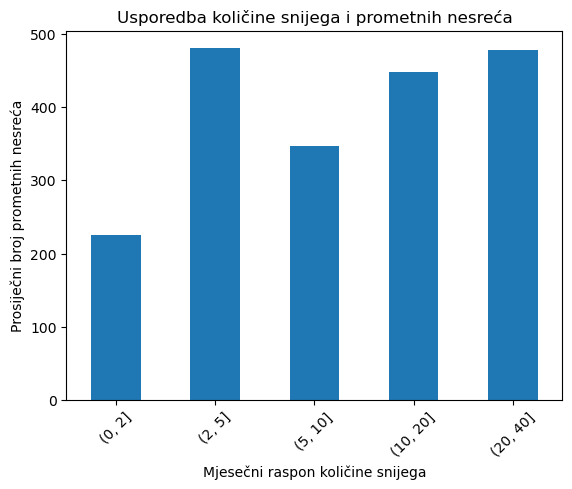

In [27]:
df_r1_snow = df[
    (df["REGION"] == 1) &
    (df["snowfall_sum"] > 0)
].copy()

df_r1_snow["snow_bin"] = pd.cut(
    df_r1_snow["snowfall_sum"],
    bins=[0, 2, 5, 10, 20, 40]
)

snow_injury_r1 = (
    df_r1_snow
    .groupby("snow_bin", observed=False)["crashes"]
    .mean()
)

plt.figure()
snow_injury_r1.plot(kind="bar")
plt.xlabel("Mjesečni raspon količine snijega")
plt.ylabel("Prosiječni broj prometnih nesreća")
plt.title("Usporedba količine snijega i prometnih nesreća")
plt.xticks(rotation=45)
plt.show()


Prvi graf prikazuje kako se prosječan broj prometnih nesreća mijenja s obzirom na količinu snijega tijekom mjeseca. Vidljivo je da se broj nesreća ne povećava proporcionalno s rastom količine snijega. Razlike nisu izrazito velike niti pokazuju jasan linearan trend. Ovakav rezultat može se objasniti prilagodbom ponašanja vozača u zimskim uvjetima, kao i povećanim oprezom tijekom vožnje.

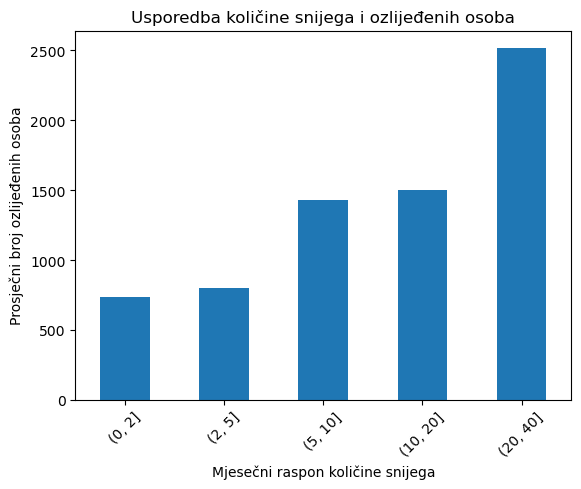

In [28]:
df_r1_snow = df[
    (df["REGION"] == 1) &
    (df["snowfall_sum"] > 0)
].copy()

df_r1_snow["snow_bin"] = pd.cut(
    df_r1_snow["snowfall_sum"],
    bins=[0, 2, 5, 10, 20, 40]
)

snow_injury_r1 = (
    df_r1_snow
    .groupby("snow_bin", observed=False)["injured_sum"]
    .mean()
)

plt.figure()
snow_injury_r1.plot(kind="bar")
plt.xlabel("Mjesečni raspon količine snijega")
plt.ylabel("Prosječni broj ozlijeđenih osoba")
plt.title("Usporedba količine snijega i ozlijeđenih osoba")
plt.xticks(rotation=45)
plt.show()


Drugi graf prikazuje odnos između količine snijega i prosječnog broja ozlijeđenih osoba. Za razliku od broja prometnih nesreća, ovdje se vidi jasniji trend rasta. S povećanjem količine snijega dolazi do velikog porasta broja ozlijeđenih osoba, posebno u višim rasponima snijega. To upućuje na zaključak da su prometne nesreće u uvjetima veće količine snijega rjeđe nego što bi se očekivalo, ali su njihove posljedice ozbiljnije.

Na temelju ovih grafova može se zaključiti da snijeg u regiji s izraženim zimskim uvjetima ima veći utjecaj na težinu prometnih nesreća nego na njihov broj.

### Utjecaj kiše na prometne nesreće

Na prikazanim grafovima analiziran je utjecaj mjesečne količine kiše na prometne nesreće i broj ozlijeđenih osoba. Analiza je provedena za regiju 1 (Northeast), koja je odabrana zbog  česte kiše i izraženih sezonskih razlika što omogućuje smisleniju usporedbu utjecaja kiše na promet. Podaci obuhvaćaju razdoblje od 2016. do 2018. godine, pri čemu su kao i prije, rezultati agregirani na mjesečnoj razini.

Na x-osi oba grafa prikazani su mjesečni rasponi ukupne količine kiše (u milimetrima), dok je na y-osi prvog grafa prikazan prosječni broj prometnih nesreća, a na drugom grafu prosječni broj ozlijeđenih osoba u tim nesrećama.

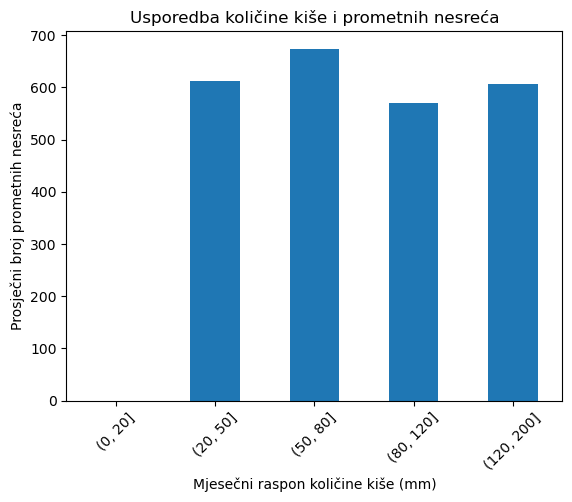

In [29]:
df_r2_rain = df[
    (df["REGION"] == 2) &
    (df["total_precipitation"] > 0)
].copy()

df_r2_rain["rain_bin"] = pd.cut(
    df_r2_rain["total_precipitation"],
    bins=[0, 20, 50, 80, 120, 200]
)

rain_injury_r2 = (
    df_r2_rain
    .groupby("rain_bin", observed=False)["crashes"]
    .mean()
)

plt.figure()
rain_injury_r2.plot(kind="bar")
plt.xlabel("Mjesečni raspon količine kiše (mm)")
plt.ylabel("Prosječni broj prometnih nesreća")
plt.title("Usporedba količine kiše i prometnih nesreća")
plt.xticks(rotation=45)
plt.show()

Prvi graf pokazuje da se broj prometnih nesreća ne povećava s rastom količine kiše. Broj nesreća ostaje relativno stabilan kroz različite raspone kiše. To govori da sama količina kiše nema snažan utjecaj na broj prometnih nesreća što može biti posljedica prilagodbe vozača uvjetima na cesti, poput smanjenja brzine i povećanog opreza tijekom kišnih razdoblja.

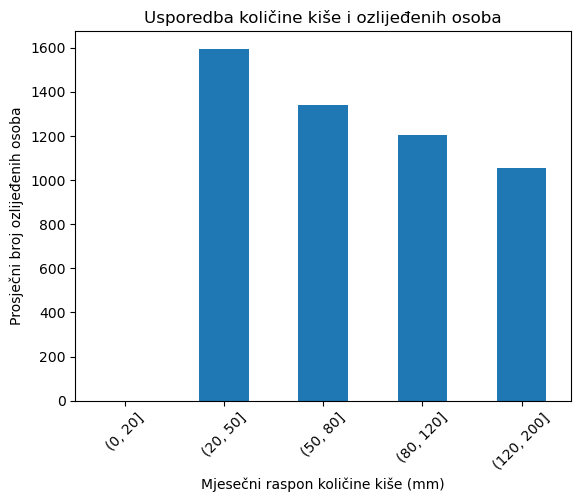

In [30]:
df_r2_rain = df[
    (df["REGION"] == 2) &
    (df["total_precipitation"] > 0)
].copy()

df_r2_rain["rain_bin"] = pd.cut(
    df_r2_rain["total_precipitation"],
    bins=[0, 20, 50, 80, 120, 200]
)

rain_injury_r2 = (
    df_r2_rain
    .groupby("rain_bin", observed=False)["injured_sum"]
    .mean()
)

plt.figure()
rain_injury_r2.plot(kind="bar")
plt.xlabel("Mjesečni raspon količine kiše (mm)")
plt.ylabel("Prosječni broj ozlijeđenih osoba")
plt.title("Usporedba količine kiše i ozlijeđenih osoba")
plt.xticks(rotation=45)
plt.show()

Drugi graf, koji prikazuje odnos između količine kiše i broja ozlijeđenih osoba, pokazuje trend. Vidi se da se s porastom količine oborina prosječan broj ozlijeđenih osoba smanjuje. Ovakav rezultat može ukazivati na to da tijekom intenzivnijih kiša dolazi do manjeg broja teških sudara, vjerojatno zbog sporije i opreznije vožnje, iako se same prometne nesreće i dalje događaju.

Na temelju ovih grafova može se zaključiti da kiša u regiji 1 nema snažan utjecaj na ukupni broj prometnih nesreća, ali može imati utjecaj na njihove posljedice. Za razliku od snijega, koji pokazuje jasnu povezanost s težinom ozljeda, kiša se u ovom slučaju pokazuje kao vremenski čimbenik koji više utječe na ponašanje vozača nego na ozbiljnost ishoda prometnih nesreća.

### Utjecaj temperature na prometne nesreće

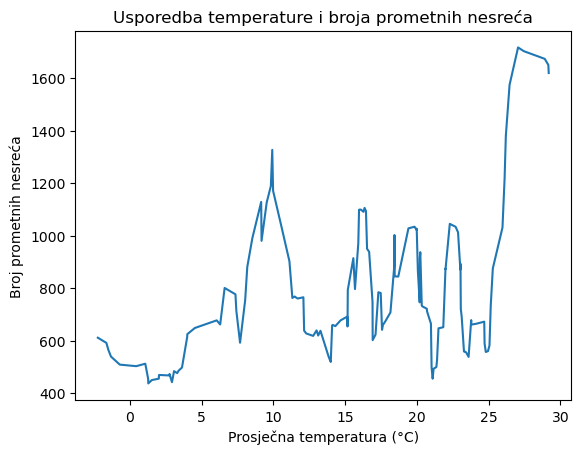

In [31]:
df_temp = df.sort_values("avg_temperature")
df_temp["injured_smooth"] = df_temp["injured_sum"].rolling(8, center=True).mean()

df_temp["crashes_smooth"] = df_temp["crashes"].rolling(8, center=True).mean()

plt.figure()
plt.plot(df_temp["avg_temperature"], df_temp["crashes_smooth"])
plt.xlabel("Prosječna temperatura (°C)")
plt.ylabel("Broj prometnih nesreća")
plt.title("Usporedba temperature i broja prometnih nesreća")
plt.show()

Na prvom grafu prikazana je usporedba prosječne temperature i broja prometnih nesreća za sve regije zajedno. Na x-osi nalazi se prosječna mjesečna temperatura izražena u stupnjevima celzija, dok je na y-osi prikazan broj prometnih nesreća. Na prvi pogled može se vidjeti da s porastom temperature raste i broj nesreća, osobito pri višim temperaturama, gdje se pojavljuju izraženiji skokovi. Međutim, ovakav graf može biti loš jer ne uzima u obzir razlike između pojedinih regija.

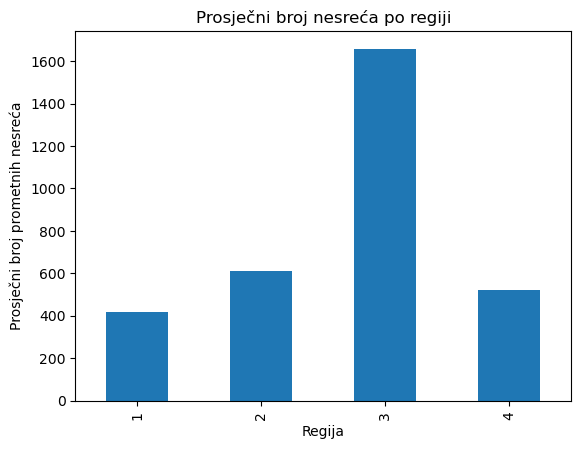

In [32]:
df.groupby("REGION")["crashes"].sum()

df.groupby("REGION")["crashes"].mean()

crashes_region = df.groupby("REGION")["crashes"].mean()

plt.figure()
crashes_region.plot(kind="bar")
plt.xlabel("Regija")
plt.ylabel("Prosječni broj prometnih nesreća")
plt.title("Prosječni broj nesreća po regiji")
plt.show()


Drugi graf prikazuje prosječan broj prometnih nesreća po regijama. Ovdje se jasno vidi da regija 3 ima puno veći prosječan broj nesreća u odnosu na ostale regije. Budući da je regija 3 najtoplija regija u promatranom skupu podataka, ovo objašnjava zašto se na prethodnom grafu pri višim temperaturama pojavljuje veći broj nesreća. Znači, veći broj nesreća nije nužno posljedica temperature, već činjenice da ta regija općenito ima više prometa i nesreća neovisno o vremenskim uvjetima.

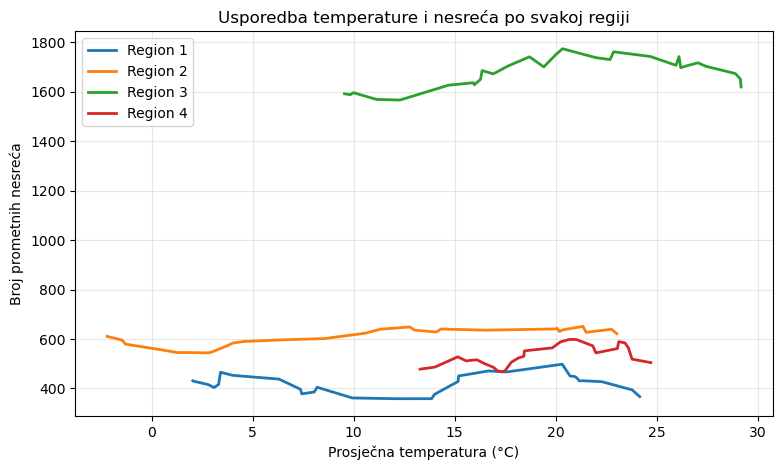

In [33]:
plt.figure(figsize=(9, 5))

for r in sorted(df["REGION"].unique()):
    df_r = df[df["REGION"] == r].sort_values("avg_temperature")
    smooth = df_r["crashes"].rolling(8, center=True).mean()
    plt.plot(df_r["avg_temperature"], smooth, linewidth=2, label=f"Region {r}")

plt.xlabel("Prosječna temperatura (°C)")
plt.ylabel("Broj prometnih nesreća")
plt.title("Usporedba temperature i nesreća po svakoj regiji")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Treći graf prikazuje odnos temperature i broja prometnih nesreća zasebno za svaku regiju. Na x-osi je ponovno prosječna temperatura, a na y-osi broj nesreća, pri čemu je svaka regija prikazana vlastitom linijom. Ovaj graf daje najjasniji uvid u stvarni odnos temperature i nesreća. Vidi se da je unutar svake regije broj nesreća relativno stabilan kroz cijeli raspon temperatura, bez trenda rasta ili pada. To upućuje na zaključak da temperatura sama po sebi nema snažan izravan utjecaj na broj prometnih nesreća, već da su razlike koje se vide u agregiranim podacima prvenstveno posljedica regionalnih razlika, a ne temperature kao takve.

Iako agregirani podaci mogu pokazivati povezanost temperature i broja nesreća, detaljnija analiza po regijama pokazuje da je ta povezanost nepostojeća. Ovi grafovi zajedno ilustriraju važnost razdvajanja podataka po regijama kako bi se izbjegli pogrešni zaključci temeljeni na prosjecima.

### Broj prometnih nesreća po godinama

In [34]:
monthly_yearly = (
    df
    .groupby(["YEAR", "MONTH"])["crashes"]
    .mean()
    .reset_index()
)


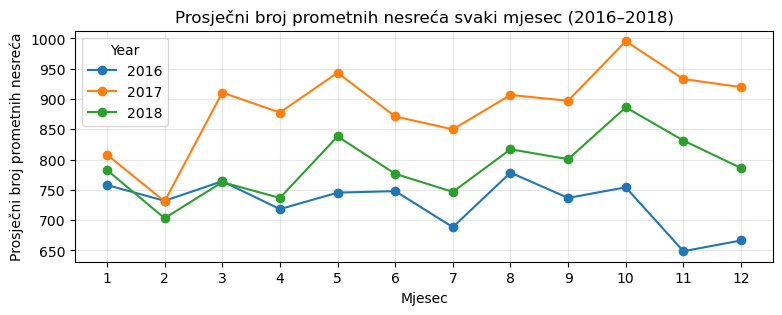

In [35]:
plt.figure(figsize=(9, 3))

for year in sorted(monthly_yearly["YEAR"].unique()):
    data_y = monthly_yearly[monthly_yearly["YEAR"] == year]
    plt.plot(
        data_y["MONTH"],
        data_y["crashes"],
        marker="o",
        label=str(year)
    )

plt.xlabel("Mjesec")
plt.ylabel("Prosječni broj prometnih nesreća")
plt.title("Prosječni broj prometnih nesreća svaki mjesec (2016–2018)")
plt.xticks(range(1, 13))
plt.legend(title="Year")
plt.grid(alpha=0.3)
plt.show()

Na ovom grafu je prikazan prosječan broj prometnih nesreća po mjesecima za razdoblje od 2016. do 2018. godine, pri čemu je svaka godina predstavljena zasebnom linijom. Na x-osi nalaze se mjeseci u godini (1–12), dok y-os prikazuje prosječan broj prometnih nesreća. Ovakav prikaz omogućuje usporedbu sezonalnih obrazaca između različitih godina.

Vidi se da sve tri godine pokazuju sličan sezonski obrazac, iako se apsolutne vrijednosti razlikuju. Tijekom proljetnih mjeseci, osobito između ožujka i svibnja, vidi se porast broja nesreća. Nakon toga dolazi do blagog pada tijekom ljeta, dok se drugi porast pojavljuje krajem ljeta i početkom jeseni, posebno oko kolovoza i listopada. U zimskim mjesecima, osobito u studenom i prosincu, broj nesreća ponovno pada.

Godina 2017. u gotovo svim mjesecima ima najveći prosječan broj nesreća u usporedbi s 2016. i 2018., što se poklapa s ranijim analizama koje su pokazale da je ta godina ukupno imala najviše prometnih nesreća. Oblik krivulje ostaje vrlo sličan kod svih godina, što upućuje na postojanje konzistentnog sezonskog trenda, neovisno o godini.

Ovaj graf sugerira da na broj prometnih nesreća značajno utječu sezonski čimbenici, poput povećane količine prometa u proljeće i jesen (npr. povratak s godišnjih odmora, početak školske godine), dok sama godina ima manji utjecaj na obrazac kretanja, već uglavnom na ukupnu razinu broja nesreća.

## Kritički osvrt

Razvijena analiza utjecaja vremenskih uvjeta na prometne nesreće pokazala se kao izvedivo rješenje za analizu podataka. Korištenjem stvarnih podataka o prometnim nesrećama u kombinaciji s meteorološkim podacima dobivenima putem javno dostupnog API-ja omogućena je analiza sezonalnih i regionalnih obrazaca te usporedba broja nesreća i težine njihovih posljedica u različitim vremenskim uvjetima.

Arhitektura se temelji na jednostavnim i lako dostupnim alatima, poput SQLite baze podataka i REST API sučelja, što omogućuje jednostavnu implementaciju i pristup podacima. Takav pristup je prikladan za projekte manjeg opsega, ali ima određena ograničenja kada je riječ o radu s većim količinama podataka ili složenijim aplikacijama, gdje bi bilo potrebno koristiti naprednija rješenja za pohranu i obradu podataka.

Glavna ograničenja analize proizlaze iz samih podataka. Podaci su agregirani na mjesečnoj razini i grupirani po regijama, bez točnih informacija o lokaciji i vremenu pojedinih nesreća. Zbog toga nije moguće precizno povezati svaku nesreću sa specifičnim vremenskim uvjetima u trenutku nesreće već se analiza temelji na općim trendovima i obrascima. Unatoč tim ograničenjima, analiza daje smislen uvid u utjecaj vremenskih uvjeta na prometne nesreće i može poslužiti kao dobra osnova za daljnja, detaljnija istraživanja.

## Zaključak

U ovom projektu je provedena analiza utjecaja vremenskih uvjeta na prometne nesreće koristeći podatke prometnih nesreća SAD-a za razdoblje od 2016. do 2018. godine u kombinaciji s meteorološkim podacima dobivenim od Open-Meteo API-ja. Odrađena je analiza sezonalnih, regionalnih i vremenskim obrazaca prometnih nesreća.

Rezultati analize pokazuju postojanje sezonalnosti u broju prometnih nesreća s dva vrhunca u proljetnom i kasno ljetnom razdoblju. Zimski mjeseci su obilježeni manjim brojem nesreća. Analiza po regijama pokazuje veće razlike u ukupnom broju nesreća pri čemu su te razlike imale veći utjecaj na ukupne rezultate od same temperature zraka. Iako se na globalnoj razini može uočiti povezanost između viših temperatura i većeg broja nesreća, detaljnija analiza po regijama pokazuje da temperatura sama po sebi nije presudan čimbenik kod prometnih nesreća.

S druge strane, analiza kiše i snijega ukazala je na to da vremenski uvjeti imaju veći utjecaj na težinu posljedica prometnih nesreća nego na njihov broj. U uvjetima povećane količine snijega ili obilnije kiše broj prometnih nesreća ostaje relativno isti dok se prosječan broj ozlijeđenih povećava. To upućuje na povećani rizik težih ishoda u nepovoljnim vremenskim uvjetima. 

Iako dobiveni rezultati ukazuju na to da vremenski uvjeti imaju veći utjecaj na težinu posljedica prometnih nesreća, također potvrđuju važnost razmatranja više vremenskih i prostornih čimbenika prilikom analize prometne sigurnosti te mogu poslužiti kao temelj za daljnja, detaljnija istraživanja.

## Literatura

[1] Pallets Projects, “Flask Documentation,” Flask Web Framework, [Online]. Dostupno: https://flask.palletsprojects.com/ [Pristupljeno: siječanj 2026.]

[2] Python Software Foundation, “sqlite3 — DB-API 2.0 interface for SQLite databases,” [Online]. Dostupno: https://docs.python.org/3/library/sqlite3.html [Pristupljeno: siječanj 2026.]

[3] Pallets Projects, “Using SQLite 3 with Flask,” [Online]. Dostupno: https://flask.palletsprojects.com/en/stable/patterns/sqlite3/ [Pristupljeno: siječanj 2026.]

[4] J. Bown, “US 2020 Traffic Accidents,” Kaggle Datasets, 2021. [Online]. Dostupno: https://www.kaggle.com/datasets/jonbown/us-2020-traffic-accidents [Pristupljeno: siječanj 2026.]

[5] Open-Meteo, “Open-Meteo: Free Weather API,” Open-Meteo Documentation, [Online]. Dostupno: https://open-meteo.com/ [Pristupljeno: siječanj 2026.]

[6] OpenAI, ChatGPT: Prompt razgovora s CHAT-GPT-om: Dostupno: https://chatgpt.com/share/69724b58-dec4-8011-89ec-0fbd4888fb6f [Pristupljeno: siječanj 2026.]